#### Import Libraries

In [1]:
# Standard libraries
import os
import random
import hashlib
import shutil
from pathlib import Path

# Data handling
import pandas as pd
import numpy as np

# Image handling
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Deep Learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow Keras layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Activation,
    Rescaling,
    Dropout,
)

# Data Augmentation
from tensorflow.keras.layers import (
    RandomFlip,
    RandomRotation,
    RandomContrast,
    RandomZoom,
    RandomTranslation)


# Optimizers and callbacks
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint, EarlyStopping

# Pre-trained model
from tensorflow.keras.applications import ResNet50 

# Hyperparamaeter tuning
import keras_tuner as kt

# Deployment
import gradio as gr


seed = 111


2025-05-06 00:21:52.841275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746487312.859337    4010 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746487312.866468    4010 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746487312.881556    4010 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746487312.881583    4010 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746487312.881585    4010 computation_placer.cc:177] computation placer alr

# Data Understanding

In [2]:
dataset_path = 'Dataset'
cleaned_dataset_path = 'Cleaned_Dataset'
subsets = ['Training','Testing'] # Dataset divided into 2 subsets: training and testing
diagnoses = ['glioma','meningioma','notumor','pituitary']

In [3]:
def load_images(dataset_path,subsets, display=['basic','full']):
    image_data = []
    
    for subset in subsets: # goes through the 2 subsets training and testing
        subset_path = os.path.join(dataset_path,subset)
        diagnoses = os.listdir(subset_path) # Returns a list of diagnoses
    
        for diag in diagnoses: # iterates over the diagnoses
            diagnoses_folder = os.path.join(subset_path, diag )
            for img_file in os.listdir(diagnoses_folder):
                img_path = os.path.join(diagnoses_folder, img_file) # gets the image path within the diagnoses folder 
                if display == 'full':
                    with Image.open(img_path) as img: 
                        width, height = img.size # Collects the width, height, and mode of the images
                        mode = img.mode
                        img_array= np.array(img) #image converted to numpy array
                        image_data.append({ # adds all the collected info for each image to the list
                            'subset':subset,
                            'diagnosis': diag,
                            'width': width,
                            'height': height,
                            'mode': mode,
                            'image': img_array
                        })
                elif display == 'basic':
                    image_data.append((diag,img_path))
    return image_data

    

In [5]:
df = pd.DataFrame(load_images(dataset_path,subsets))

In [6]:
df.head()

subset diagnosis  width  height mode  \
0  Training    glioma    512     512  RGB   
1  Training    glioma    512     512  RGB   
2  Training    glioma    512     512  RGB   
3  Training    glioma    512     512  RGB   
4  Training    glioma    512     512  RGB   

                                               image  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

In [7]:
# Number of images for training and testing for each diagnosis
table = df.groupby(['subset', 'diagnosis']).size().unstack()
table

diagnosis  glioma  meningioma  notumor  pituitary
subset                                           
Testing       300         306      405        300
Training     1321        1339     1595       1457

In [8]:
df_train = df[df['subset'] == 'Training']
df_test = df[df['subset'] == 'Testing']
training_data = table.loc['Training'] 
testing_data = table.loc['Testing']

In [10]:
def plot_data_splits(table, df_train, df_test,training_data,testing_data):

    fig, ax = plt.subplots(ncols = 3,figsize=(20,14))

    # training data split
    ax[0].pie(training_data, labels= training_data.index,colors = ["#F9ED69", "#F08A5D", "#B83B5E", "#6A2C70"], 
        autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(df_train['diagnosis'].value_counts()) / 100),
        textprops={'fontsize': 20})
    ax[0].set_title("Training")

    # train test split
    ax[1].set_title("Train Test Split")
    ax[1].pie(
        [len(df_train), len(df_test)], 
        labels=['Train', 'Test'], 
        colors=['#144272', '#FFA500'],  
        autopct=lambda p: '{:.0f}%\n{:,.0f}'.format(p, p * (len(df_train) + len(df_test)) / 100),
        startangle=85, 
        textprops={'fontsize': 20}
    )

    # testing data split
    ax[2].set_title('Testing Data')
    ax[2].pie(testing_data, labels= testing_data.index, colors=["#F9ED69", "#F08A5D", "#B83B5E", "#6A2C70"], 
        autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(df_test['diagnosis'].value_counts()) / 100),
        textprops={'fontsize': 20 })

    plt.show()


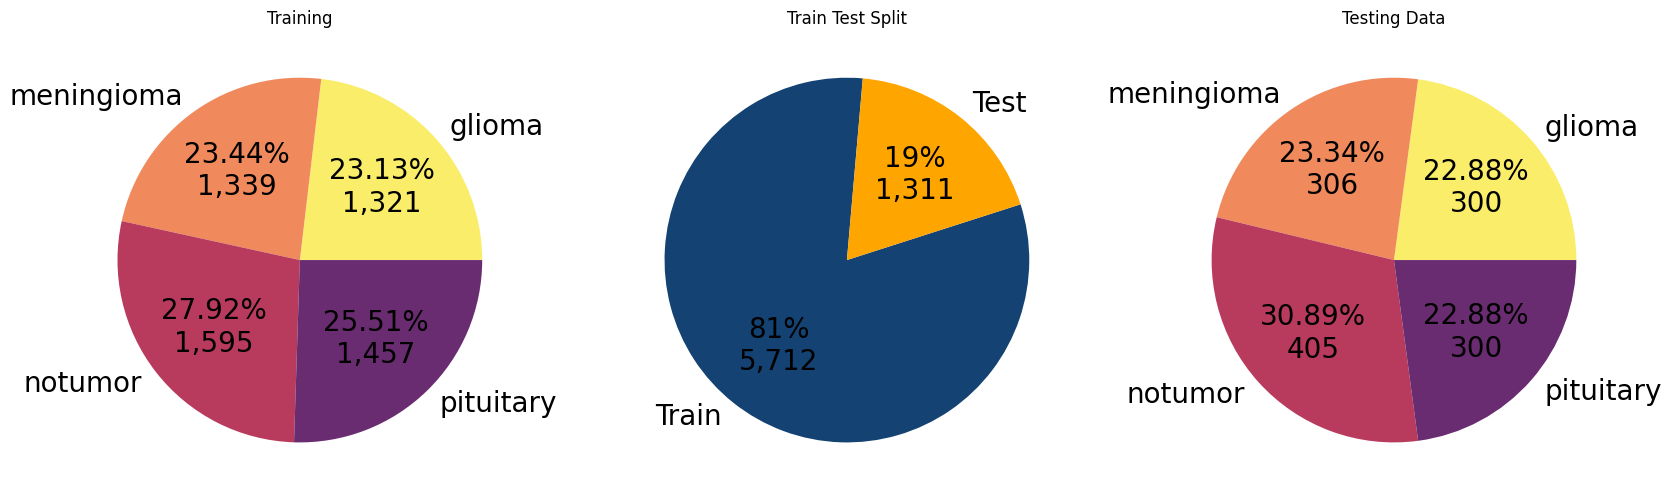

In [10]:
plot_data_splits(table,df_train,df_test,training_data,testing_data)

In [11]:
def visualize_sample_images(image_data, diagnoses, k):
    # Take 5 images from each diagnosis and visualise them, raw images without processing
    for diag in diagnoses:
        samples = [item for item in image_data if item['diagnosis'] == diag]
        samples = random.sample(samples, k)  

        plt.figure(figsize=(15, 3))
        for i, item in enumerate(samples):
            plt.subplot(1, k, i + 1)
            plt.imshow(item['image'])
            plt.axis('off')
        plt.suptitle(f"Diagnosis: {diag}", fontsize=20)
        plt.show()
    

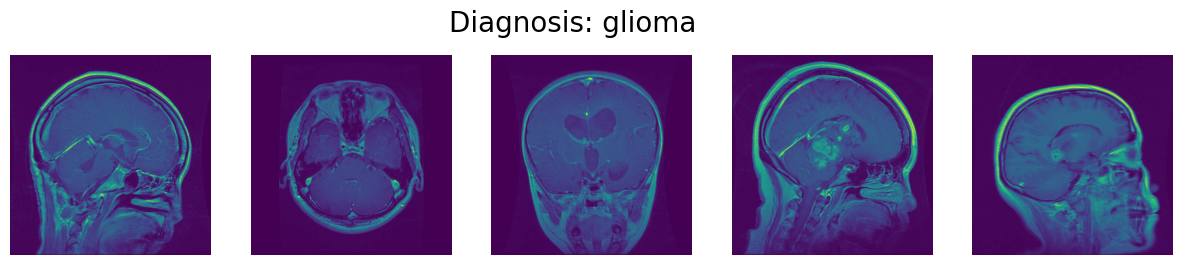

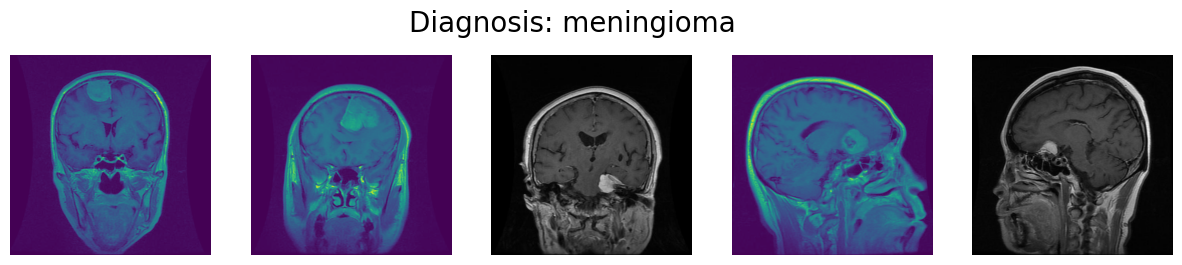

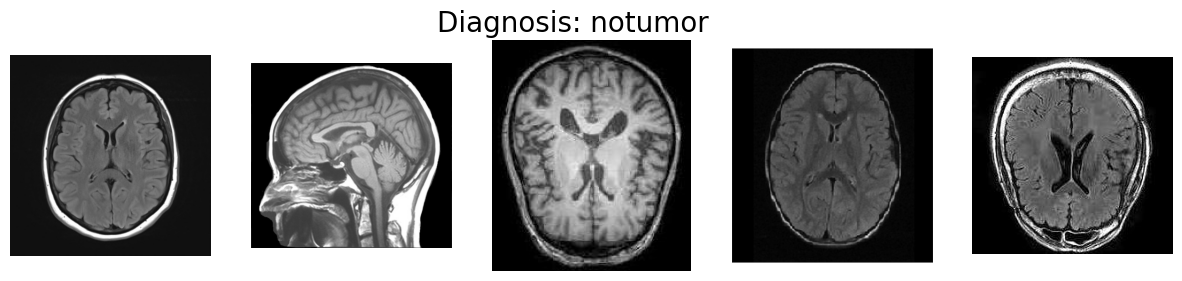

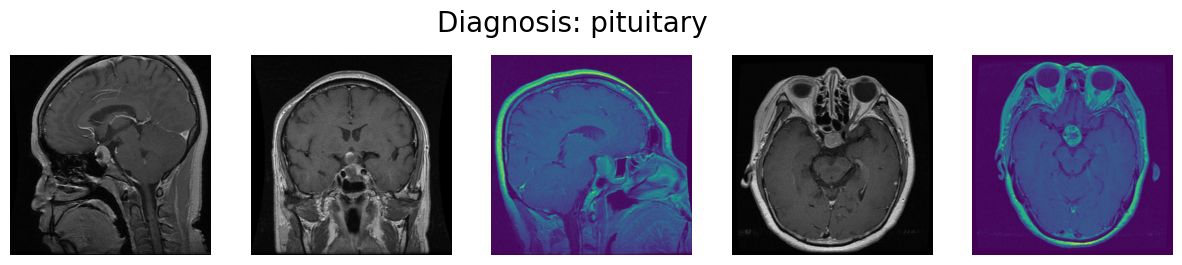

In [12]:
visualize_sample_images(image_data, diagnoses,5)


In [13]:
# Displaying the mode of images, shows inconsistency across images
df['mode'].value_counts()

mode
RGB     3926
L       3093
RGBA       3
P          1
Name: count, dtype: int64

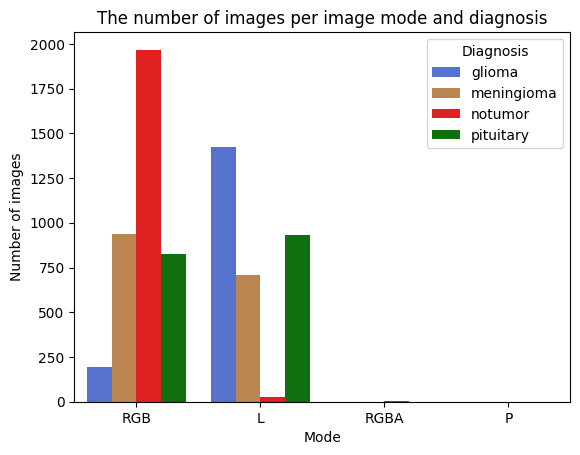

In [14]:
# The number
sns.countplot(data=df, x='mode', hue='diagnosis', palette=['royalblue', 'peru', 'red', 'green'],legend='full')
plt.title('The number of images per image mode and diagnosis')
plt.xlabel('Mode')
plt.ylabel('Number of images')
plt.legend(title='Diagnosis')
plt.show()

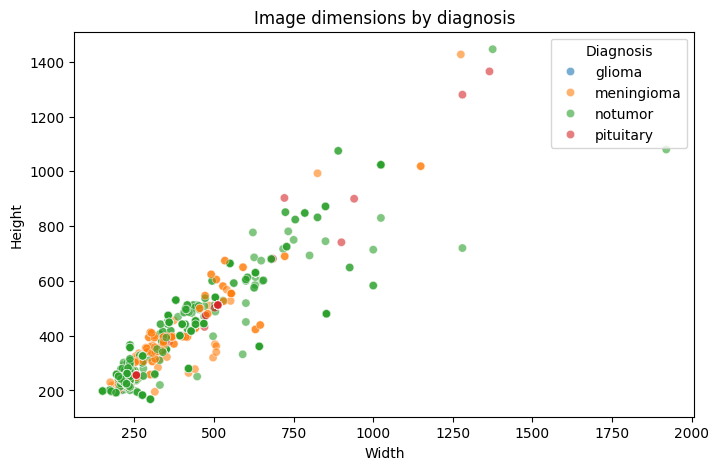

In [15]:
# Distribution of image dimensions 
plt.figure(figsize=(8,5))
sns.scatterplot(data = df, x='width',y='height', hue='diagnosis',alpha=0.6)
plt.title('Image dimensions by diagnosis')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend(title='Diagnosis')
plt.show()

# Data Preparation

In [4]:
# Hashing images using MD5
# Source: https://mkyong.com/python/python-md5-hashing-example
def hash_image(file_path):
    hasher = hashlib.md5()
    with open(file_path, 'rb') as f:
        hasher.update(f.read())
    return hasher.hexdigest()

# Remove duplicates using MD5 hash
# If two images have the same hash code, they are duplicate and we skip one of them
def remove_duplicates(images_with_labels):
    seen_hashes = {} # dict to stores hashes
    unique_images = [] # list of unique images
    duplicates= [] # List of duplicate images
    for diag, img_path in images_with_labels:
        h = hash_image(img_path)
        if h not in seen_hashes: 
            seen_hashes[h] = img_path
            unique_images.append((diag, img_path)) 
        else:
            duplicates.append((img_path,diag,seen_hashes[h]))
            print(f"Duplicate found and skipped: {img_path}")
    return unique_images, duplicates

# we take 2 duplicate images from same folder and visualise them
def visualise_duplicate_images(duplicates):
    img_path_1, diag, img_path_2 = duplicates[0]

    image_data = [
        {'image': plt.imread(img_path_1), 'label': 'Image 1', 'path': img_path_1},
        {'image': plt.imread(img_path_2), 'label': 'Image 2', 'path': img_path_2}
    ]
    plt.figure(figsize=(12,5))
    for i, item in enumerate(image_data):
        plt.subplot(1, 2, i+1)
        plt.imshow(item['image'])
        plt.axis('off')
        plt.title(f"{item['label']}\n{os.path.relpath(item['path'])}", fontsize=10)

    plt.suptitle("Example of duplicate images", fontsize=14)
    plt.tight_layout()
    plt.show()


# Shuffle and split data
def shuffle_and_split(images_with_labels, test_ratio=0.2): # we keep 80% of the data for training and 20% for testing 
    diags, paths = zip(*images_with_labels)
    return train_test_split(paths, diags, test_size=test_ratio, stratify=diags, random_state=111)

# Copy images to new cleaned dataset folder
def save_cleaned_dataset(split_data, cleaned_dataset_path):
    for subset, img_paths, diags in split_data:
        for img_path, diag in zip(img_paths, diags):
            dest_folder = Path(cleaned_dataset_path) / subset / diag
            dest_folder.mkdir(parents=True, exist_ok=True)
            shutil.copy2(img_path, dest_folder / os.path.basename(img_path))



# Making sure this happens only once
if os.path.exists(cleaned_dataset_path):
    print("Clean Dataset already exists")
else:
    images_with_labels = load_images(dataset_path, subsets,display='basic')
    unique_images, duplicates = remove_duplicates(images_with_labels)
    train_paths, test_paths, train_diags, test_diags = shuffle_and_split(unique_images)

    save_cleaned_dataset([
        ("Training", train_paths, train_diags),
        ("Testing", test_paths, test_diags)
    ], cleaned_dataset_path)

    print("Dataset is clean")

Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0211.jpg
Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0238.jpg
Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0251.jpg
Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0281.jpg
Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0366.jpg
Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0617.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0012.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0014.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0024.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0029.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0077.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0078.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0079.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0081.jpg
Duplicate found 

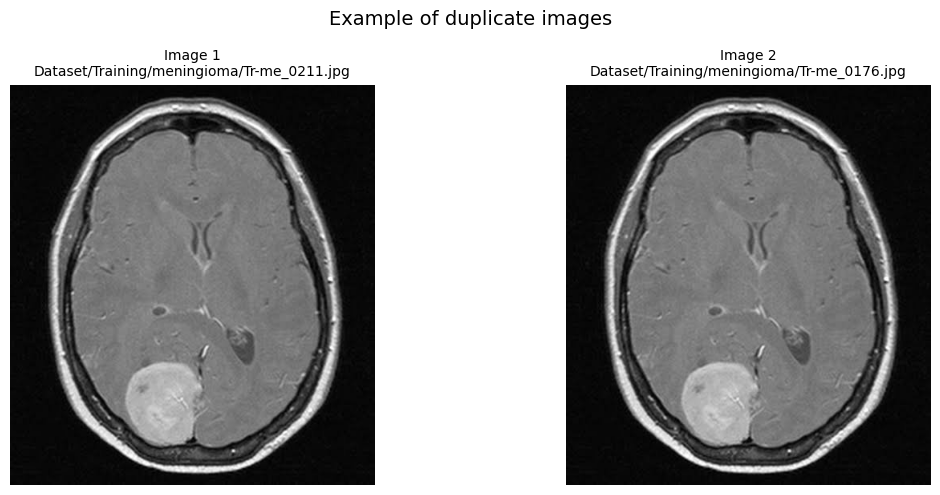

In [5]:
visualise_duplicate_images(duplicates)

In [6]:
df = pd.DataFrame(load_images(cleaned_dataset_path,subsets,display='full'))
# Number of images for training and testing for each diagnosis
table = df.groupby(['subset', 'diagnosis']).size().unstack()
df_train = df[df['subset'] == 'Training']
df_test = df[df['subset'] == 'Testing']
training_data = table.loc['Training'] 
testing_data = table.loc['Testing']

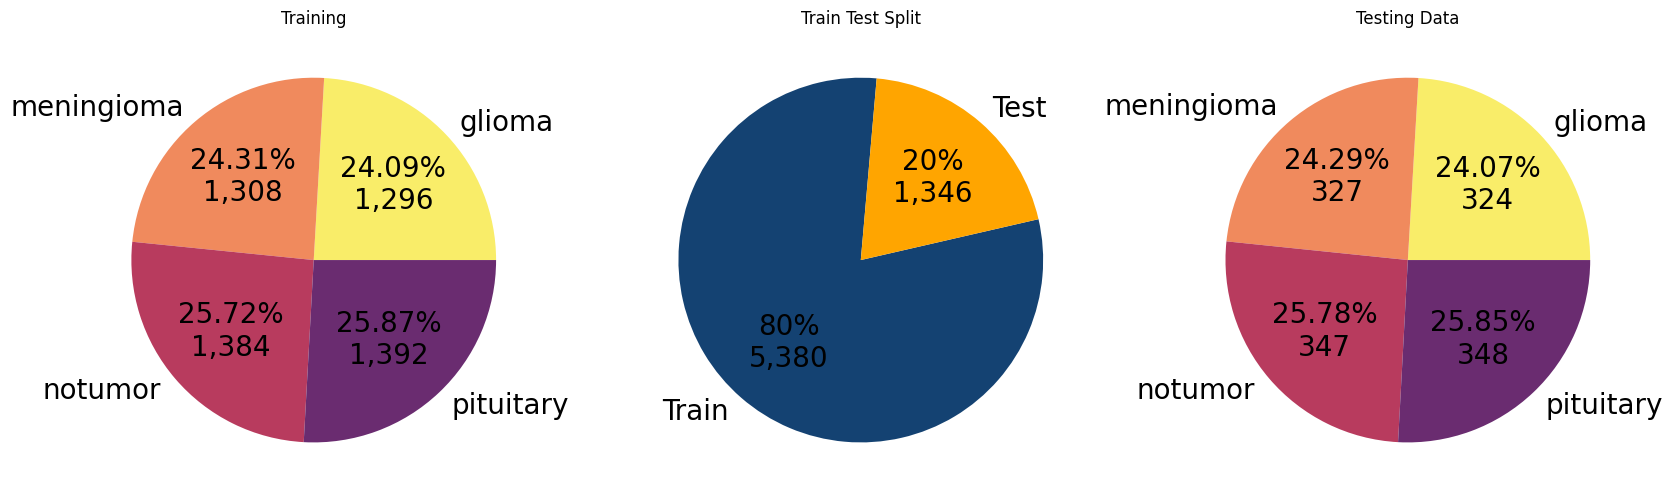

In [14]:
plot_data_splits(table,df_train,df_test,training_data,testing_data)

In [2]:
train_dir = 'Cleaned_Dataset/Training' # train images directory
test_dir = 'Cleaned_Dataset/Testing'  # test images directory
batch_size= 32 # define batch size
image_size = 224 # define image size

In [3]:
#load training data using image_dataset_from_directory
#source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,                                     
    label_mode= 'int',                             # Labels are encoded as a integers
    validation_split= 0.2,                         # 20% of the training data will be used for training
    color_mode = 'rgb',                            # Load all images in RGB mode 
    batch_size = batch_size,                       # number of images processed in each batch
    image_size = (image_size,image_size),          # image size is 224x224 (this will fix the imbalance we plotted earlier by using a uniform size)
    seed = seed,
    subset = 'training'                            # Training subset
)

#load validation data using image_dataset_from_directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode= 'int',
    validation_split= 0.2,
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (image_size,image_size),
    shuffle = True,                                
    seed = seed,
    subset = 'validation'                           # Validation subset
)

#load validation data using image_dataset_from_directory
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode= 'int',
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (image_size, image_size)
)
# This will be used later to get the class names (diagnoses)
class_names= test_ds.class_names

Found 5380 files belonging to 4 classes.
Using 4304 files for training.


I0000 00:00:1746487327.283380    4010 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 5380 files belonging to 4 classes.
Using 1076 files for validation.
Found 1346 files belonging to 4 classes.


In [4]:
# Data augmentation
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/layers
data_augmentation = Sequential([
    RandomFlip('horizontal'),                                                             # Randomly flips images horizontally
    RandomRotation(0.03,fill_mode='constant'),                                            # Randomly rotates images by ±10 degrees
    RandomContrast(0.1),                                                                  # Randomly adjusts contrast by ±10%
    RandomZoom(height_factor=0.01, width_factor=0.05),                                    # Randomly zooms in/out up to 1% vertically and 5% horizontally
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),   # Randomly shifts the image by 0.15% of the height and width
])

rescale = Rescaling(1./255)  # Rescale pixel values to [0, 1] range

In [5]:
# Source: https://www.tensorflow.org/tutorials/images/data_augmentation

AUTOTUNE = tf.data.AUTOTUNE # Allows TensorFlow to automatically choose the optimal number of parallel threads to improve performance

# training data augmented and rescaled (Images were already resized when loaded so we don't need to resize again)
train_ds = train_ds.map(
    lambda x, y: (rescale(data_augmentation(x,training= True)), y),
    num_parallel_calls= AUTOTUNE
)

# Validation data rescaled only
val_ds = val_ds.map(
    lambda x, y: (rescale(x), y),
    num_parallel_calls= AUTOTUNE
)

# Testing data rescaled only
test_ds = test_ds.map(
    lambda x, y: (rescale(x), y),
    num_parallel_calls= AUTOTUNE
)

# Allows later elements to be prepared while the current element is being processed which improves performance
train_ds_preprocessed = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds_preprocessed = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds_preprocessed = test_ds.prefetch(buffer_size=AUTOTUNE)

In [6]:
# A function the will get one image per class (needed for augmentation visualisation and in evaluation section)
def get_one_image_per_class(dataset):
    images_per_class = {}
    
    for images, labels in dataset:
        for img, label in zip(images,labels):
            label = int(label.numpy())
            # if the image has not been stored previously, we add it
            if label not in images_per_class:
                images_per_class[label] = img.numpy()
            # we exit early once we get the 4 images   
            if len(images_per_class) == len(class_names):
                break
    return images_per_class

In [8]:
def visualize_augmentation(dataset, class_names, num_samples):
    
    images_per_class = get_one_image_per_class(dataset)
    
    # Create visualization grid
    num_classes = len(class_names) 
    fig, axes = plt.subplots(
        num_classes,
        num_samples + 1,
        figsize=(2.5*(num_samples+1), 2.5*num_classes))
    
    for class_idx in range(num_classes):
        # Original image taken earlier
        orig_img = images_per_class[class_idx]
        # Add it in the first column of each row 
        axes[class_idx, 0].imshow(orig_img)
        axes[class_idx, 0].set_title(f"Original {class_names[class_idx]}")
        axes[class_idx, 0].axis('off')
        
        for aug_idx in range(1, num_samples+1):
            # We augment the original images 
            aug_img = data_augmentation(tf.expand_dims(orig_img, 0))
            aug_img = aug_img[0].numpy()
            # Clip, limiting the values between 0 and 1 to avoid imshow warnings
            aug_img = (np.clip(aug_img, 0, 1) * 255).astype(np.uint8) 


            # then we add it to the visualisation grid
            axes[class_idx, aug_idx].imshow(aug_img)
            axes[class_idx, aug_idx].set_title(f"Augmented image {aug_idx}")
            axes[class_idx, aug_idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    

2025-05-05 01:51:45.945828: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


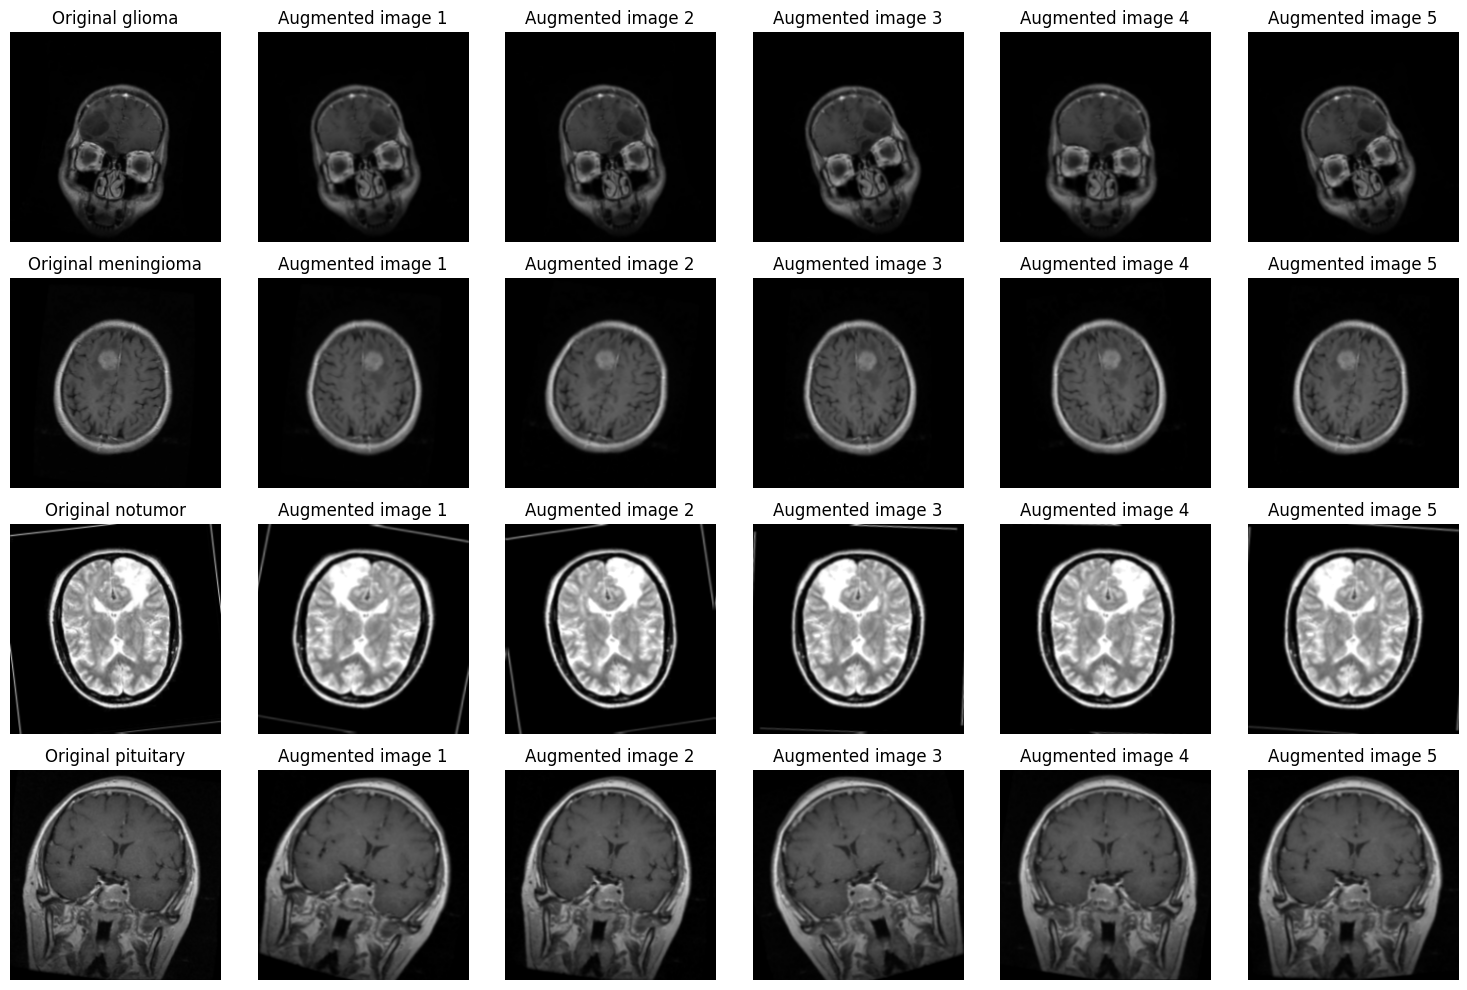

In [9]:
visualize_augmentation(
    train_ds,    
    class_names,  
    num_samples=5
)

# Modelling

## Custom CNN

In [6]:
def build_model(hp):
    model = Sequential()
    #Input layer
    model.add(Input(shape=(224, 224, 3)))

    # convolutional blocks, either 3 or 4
    num_blocks = hp.Choice("num_conv_blocks", [3, 4])
    
    # Define the list of filters to use
    filter_values = [64, 128, 256, 512]
    filters= 64

    for block in range(num_blocks):
        
        # Tunable kernel size (3x3, 4x4, or 5x5)
        kernel_size = hp.Choice(f"kernel_size_block{block+1}", [3, 4, 5])
        # Tunable pooling size (2x2 or 3x3)
        pool_size = hp.Choice(f"pool_size_block{block+1}", [2, 3])

        hp.Fixed(f"filters_block{block+1}", filters)

        # Add convolutional layer with ReLU activation
        model.add(Conv2D(filters, kernel_size, activation="relu"))
        # Add max pooling layer
        model.add(MaxPooling2D(pool_size=pool_size))

        # choosing the number of filter for the next block          
        if block < num_blocks -1 :
            multiplier = hp.Choice(f"multiplier{block + 1}",[1,2]) ## multiplier for values 
            filters= min(filters * multiplier, 512) ## maximum value is 512

    # Flattening features to one dimensional
    model.add(Flatten())

    # Adding dropout
    dropout_rate= hp.Choice("dropout_rate",[0.0,0.2,0.3,0.5])
    if dropout_rate != 0.0:
        model.add(Dropout(dropout_rate))  # only apply if not None
    
    # Tunable number of units in dense layer 
    model.add(Dense(hp.Choice("dense_units", [256, 512, 1024]),
                    activation="relu"))
    # Output layer with softmax, for the 4 diagnoses
    model.add(Dense(4, activation="softmax"))

    # optimiser, can be Adam or SGD
    optimizer_name = hp.Choice("optimizer", ["adam", "sgd"])
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-3)

    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile model with sparse categorical crossentropy (integer labels)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [7]:
# Hyperband tuner
# Source: https://keras.io/keras_tuner/api/tuners/hyperband/

tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=15,
    factor=3,
    directory="keras_tuner",
    project_name="cnn_search"
)

Reloading Tuner from keras_tuner/cnn_search/tuner0.json


In [8]:
tuner.search(
    train_ds_preprocessed,
    validation_data=val_ds_preprocessed,
    epochs=10,  
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=4)
    ]
)


In [9]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters = best_hps.values

print("Best Hyperparameters Found:")
print(best_hyperparameters)



Best Hyperparameters Found:
{'num_conv_blocks': 4, 'kernel_size_block1': 5, 'pool_size_block1': 3, 'filters_block1': 64, 'multiplier1': 2, 'kernel_size_block2': 5, 'pool_size_block2': 3, 'filters_block2': 64, 'multiplier2': 2, 'kernel_size_block3': 5, 'pool_size_block3': 2, 'filters_block3': 64, 'dropout_rate': 0.5, 'dense_units': 512, 'optimizer': 'adam', 'learning_rate': 0.0003560691697537912, 'multiplier3': 1, 'kernel_size_block4': 3, 'pool_size_block4': 2, 'filters_block4': 128, 'tuner/epochs': 15, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [10]:
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 19, 19, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,801,540 (10.69 MB)

 Trainable params: 2,801,540 (10.69 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Automatically decreasing the learning rate to reduce overfitting if the model loss does not decrease
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-6, patience=12, verbose=1)

model_mc = ModelCheckpoint('best_custom_cnn.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Combine the callbacks into a list
callbacks = [model_rlr, model_mc]


# Training the model
history = best_model.fit(
    train_ds_preprocessed,
    epochs=100,
    validation_data=val_ds_preprocessed,
    callbacks=callbacks,
    verbose=True
)

Epoch 1/100


I0000 00:00:1745864812.700461    9012 service.cc:152] XLA service 0x7f6900003520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745864812.700501    9012 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-04-28 19:26:52.804836: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745864813.269883    9012 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-28 19:26:54.004289: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_751', 4 bytes spill stores, 4 bytes spill loads

2025-04-28 19:26:54.161989: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusio

  2/135 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.2812 - loss: 1.3859 

I0000 00:00:1745864820.687853    9012 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


134/135 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4365 - loss: 1.1972

2025-04-28 19:27:07.547784: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_751', 12 bytes spill stores, 12 bytes spill loads



135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.4381 - loss: 1.1945 - val_accuracy: 0.7323 - val_loss: 0.7033 - learning_rate: 3.5607e-04
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7356 - loss: 0.6930 - val_accuracy: 0.8364 - val_loss: 0.4584 - learning_rate: 3.5607e-04
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7933 - loss: 0.5282 - val_accuracy: 0.8680 - val_loss: 0.3464 - learning_rate: 3.5607e-04
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8531 - loss: 0.4162 - val_accuracy: 0.8717 - val_loss: 0.3581 - learning_rate: 3.5607e-04
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8768 - loss: 0.3293 - val_accuracy: 0.8290 - val_loss: 0.4026 - learning_rate: 3.5607e-04
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8926 - loss: 0.2936 - val_accuracy: 0.9191 - val_loss: 0.2225 - learning_rate: 3.5607e-04
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accura

In [16]:
# Evaluate model on train, validation and test sets 
test_loss, test_acc = best_model.evaluate(val_ds_preprocessed)
print(f"Validation accuracy: {test_acc*100:0.4f}%")

test_loss, test_acc = best_model.evaluate(train_ds_preprocessed)
print(f"Train accuracy: {test_acc*100:0.4f}%")

test_loss, test_acc = best_model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9792 - loss: 0.1241
Validation accuracy: 97.7695%
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 1.0000 - loss: 1.4507e-05
Train accuracy: 100.0000%
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9892 - loss: 0.1013
Test accuracy: 98.6627%


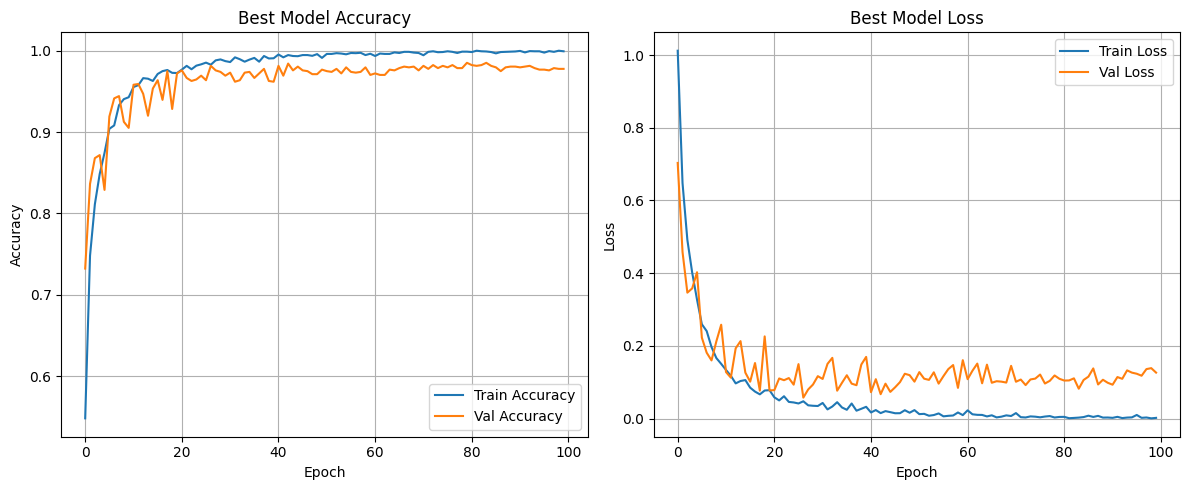

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[0].set_title('Best Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
axs[1].set_title('Best Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Resnet50

### Hyperparameter optimization

In [6]:
img_size=224

def build_model(hp):
    # Load base pre-trained ResNet50 model
    base_model = ResNet50(input_shape=(img_size, img_size, 3),
                          include_top=False,
                          weights='imagenet',
                          pooling='avg')  # already does global average pooling
    
    # Freezing the base model
    base_model.trainable = False

    x = base_model.output

    # Add dense layers with hyperparameters
    for i in range(hp.Int('num_layers', min_value=2, max_value=3)):
        units = hp.Choice(f'units_{i}', values=[128,256, 512])
        activation = hp.Choice(f'activation_{i}', values=["relu", "sigmoid"])
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)

        x = Dense(units=units, activation=activation)(x)
        x = Dropout(rate=dropout_rate)(x)

    # Output layer (4 classes)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Adam optimizer with tunable learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=learning_rate)

    # Compile model
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',  
                  metrics=['accuracy'])

    return model

In [7]:
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=15,
    factor=3,
    directory="keras_tuner",
    project_name="resnet50",
)

Reloading Tuner from keras_tuner/resnet50/tuner0.json


In [8]:
tuner.search(
    train_ds_preprocessed,
    validation_data=val_ds_preprocessed,
    epochs=10,  
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ]
)


In [9]:
best_hp = tuner.get_best_hyperparameters(1)[0]   
for k in best_hp.values:
    print(f"{k}: {best_hp.get(k)}")


num_layers: 2
units_0: 512
activation_0: sigmoid
dropout_0: 0.1
units_1: 128
activation_1: relu
dropout_1: 0.0
learning_rate: 0.001
units_2: 128
activation_2: relu
dropout_2: 0.0
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021


In [6]:
img_size=224
def build_resnet():
    # ResNet-50 feature extractor
    base = ResNet50(
        include_top=False,
        weights="imagenet",
        pooling="avg",
        input_shape=(img_size, img_size, 3)
    )
    base.trainable = False        
    x = base.output
    # Dense block 1
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.1)(x)
    # Dense block 2
    x = Dense(128, activation="relu")(x)

    outputs = Dense(4, activation="softmax")(x)   # 4 classes

    model = Model(inputs=base.input, outputs=outputs)

    return model

# build it
model = build_resnet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,702,980 (94.23 MB)

 Trainable params: 1,115,268 (4.25 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(
    train_ds_preprocessed,
    validation_data=val_ds_preprocessed,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30


I0000 00:00:1745881003.579080    1360 service.cc:152] XLA service 0x7fdf24003530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745881003.579139    1360 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-04-28 23:56:44.168511: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745881005.880263    1360 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-28 23:56:47.270934: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5364', 4 bytes spill stores, 4 bytes spill loads

2025-04-28 23:56:47.530133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusi

  1/135 ━━━━━━━━━━━━━━━━━━━━ 33:55 15s/step - accuracy: 0.3438 - loss: 1.4216

I0000 00:00:1745881013.136014    1360 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


133/135 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3892 - loss: 1.3074

2025-04-28 23:57:01.793699: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5012', 4 bytes spill stores, 4 bytes spill loads

2025-04-28 23:57:01.824472: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5012', 4 bytes spill stores, 4 bytes spill loads

2025-04-28 23:57:02.222930: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5012', 116 bytes spill stores, 116 bytes spill loads

2025-04-28 23:57:02.807645: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5012', 3940 bytes spill stores, 3920 bytes spill loads

2025-04-28 23:57:02.964604: I external

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3903 - loss: 1.3057

2025-04-28 23:57:10.656809: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1707_0', 44 bytes spill stores, 44 bytes spill loads

2025-04-28 23:57:11.070856: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1707', 484 bytes spill stores, 484 bytes spill loads

2025-04-28 23:57:16.176914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 220 bytes spill stores, 220 bytes spill loads

2025-04-28 23:57:16.439301: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1707', 488 bytes spill stores, 488 bytes spill loads

2025-04-28 23:57:16.934335: I ex

135/135 ━━━━━━━━━━━━━━━━━━━━ 43s 206ms/step - accuracy: 0.3908 - loss: 1.3049 - val_accuracy: 0.5874 - val_loss: 1.0201
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.6234 - loss: 0.9339 - val_accuracy: 0.6571 - val_loss: 0.8766
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.6655 - loss: 0.8293 - val_accuracy: 0.6431 - val_loss: 0.8586
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.6762 - loss: 0.7804 - val_accuracy: 0.6227 - val_loss: 0.9339
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.6811 - loss: 0.7506 - val_accuracy: 0.6589 - val_loss: 0.7671
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.6924 - loss: 0.7462 - val_accuracy: 0.6822 - val_loss: 0.7584
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7083 - loss: 0.7229 - val_accuracy: 0.6849 - val_loss: 0.7816
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.7270 - loss: 0.6545 - val_accuracy: 0.6

In [8]:
# saving the initial model so we can use it
model.save('resnet50_initial.keras')

In [6]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('resnet50_initial.keras')


model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-6, patience=8, verbose=1)
model_mc = ModelCheckpoint('Resnet50.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Combine the callbacks into a list
callbacks = [model_rlr, model_mc]


for layer in model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,702,980 (94.23 MB)

 Trainable params: 11,105,412 (42.36 MB)

 Non-trainable params: 13,597,568 (51.87 MB)

In [7]:
fine_tune_history = model.fit(
    train_ds_preprocessed,
    validation_data=val_ds_preprocessed,
    epochs=100,
    initial_epoch=30,  
    callbacks=callbacks
)

Epoch 31/100


I0000 00:00:1745881953.084346    4487 service.cc:152] XLA service 0x7f1000015000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745881953.084414    4487 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-04-29 00:12:33.812329: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745881956.337370    4487 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-29 00:12:38.506079: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6460', 204 bytes spill stores, 204 bytes spill loads

2025-04-29 00:12:38.702535: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_

  1/135 ━━━━━━━━━━━━━━━━━━━━ 49:47 22s/step - accuracy: 0.2500 - loss: 33.8885

I0000 00:00:1745881967.443197    4487 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


134/135 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5986 - loss: 4.2163

2025-04-29 00:12:58.226702: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6812', 12 bytes spill stores, 12 bytes spill loads

2025-04-29 00:12:58.335610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6460', 4 bytes spill stores, 4 bytes spill loads

2025-04-29 00:12:58.684573: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6460', 116 bytes spill stores, 116 bytes spill loads

2025-04-29 00:12:58.919166: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6460', 4 bytes spill stores, 4 bytes spill loads

2025-04-29 00:12:59.550924: I external/loc

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5992 - loss: 4.1970

2025-04-29 00:13:09.304975: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1707_0', 44 bytes spill stores, 44 bytes spill loads

2025-04-29 00:13:09.563210: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1707', 484 bytes spill stores, 484 bytes spill loads

2025-04-29 00:13:14.218033: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 220 bytes spill stores, 220 bytes spill loads

2025-04-29 00:13:14.888475: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 00:13:14.901187: I extern

135/135 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - accuracy: 0.5997 - loss: 4.1781 - val_accuracy: 0.4554 - val_loss: 2.4864 - learning_rate: 1.0000e-04
Epoch 32/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.7626 - loss: 0.6089 - val_accuracy: 0.7361 - val_loss: 0.7544 - learning_rate: 1.0000e-04
Epoch 33/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.7892 - loss: 0.5098 - val_accuracy: 0.7677 - val_loss: 0.6188 - learning_rate: 1.0000e-04
Epoch 34/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.7853 - loss: 0.5078 - val_accuracy: 0.7918 - val_loss: 0.5536 - learning_rate: 1.0000e-04
Epoch 35/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8283 - loss: 0.4532 - val_accuracy: 0.7584 - val_loss: 0.6475 - learning_rate: 1.0000e-04
Epoch 36/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.8307 - loss: 0.4271 - val_accuracy: 0.8058 - val_loss: 0.5185 - learning_rate: 1.0000e-04
Epoch 37/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/s

2025-04-29 00:19:37.184131: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


135/135 ━━━━━━━━━━━━━━━━━━━━ 34s 251ms/step - accuracy: 0.9346 - loss: 0.1825 - val_accuracy: 0.8634 - val_loss: 0.4534 - learning_rate: 8.0000e-05
Epoch 68/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.9369 - loss: 0.1672 - val_accuracy: 0.8857 - val_loss: 0.3765 - learning_rate: 8.0000e-05
Epoch 69/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 245ms/step - accuracy: 0.9414 - loss: 0.1518 - val_accuracy: 0.8411 - val_loss: 0.6069 - learning_rate: 8.0000e-05
Epoch 70/100
134/135 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9460 - loss: 0.1467
Epoch 70: ReduceLROnPlateau reducing learning rate to 6.399999838322402e-05.
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.9460 - loss: 0.1467 - val_accuracy: 0.8578 - val_loss: 0.4451 - learning_rate: 8.0000e-05
Epoch 71/100
  2/135 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9531 - loss: 0.1048   

2025-04-29 00:21:22.670670: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


135/135 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - accuracy: 0.9499 - loss: 0.1451 - val_accuracy: 0.9099 - val_loss: 0.2690 - learning_rate: 6.4000e-05
Epoch 72/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.9545 - loss: 0.1165 - val_accuracy: 0.9322 - val_loss: 0.2560 - learning_rate: 6.4000e-05
Epoch 73/100
  1/135 ━━━━━━━━━━━━━━━━━━━━ 1:38 738ms/step - accuracy: 0.8750 - loss: 0.2352

2025-04-29 00:22:13.286439: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


135/135 ━━━━━━━━━━━━━━━━━━━━ 34s 248ms/step - accuracy: 0.9543 - loss: 0.1183 - val_accuracy: 0.9145 - val_loss: 0.3245 - learning_rate: 6.4000e-05
Epoch 74/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.9607 - loss: 0.1072 - val_accuracy: 0.8894 - val_loss: 0.3417 - learning_rate: 6.4000e-05
Epoch 75/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.9536 - loss: 0.1244 - val_accuracy: 0.8717 - val_loss: 0.5881 - learning_rate: 6.4000e-05
Epoch 76/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.9527 - loss: 0.1254 - val_accuracy: 0.8030 - val_loss: 0.9591 - learning_rate: 6.4000e-05
Epoch 77/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9533 - loss: 0.1198 - val_accuracy: 0.8532 - val_loss: 0.5861 - learning_rate: 6.4000e-05
Epoch 78/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9624 - loss: 0.1217 - val_accuracy: 0.9136 - val_loss: 0.3269 - learning_rate: 6.4000e-05
Epoch 79/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/

In [8]:
# Evaluate model on train, validation and test sets 
test_loss, test_acc = model.evaluate(val_ds_preprocessed)
print(f"Validation accuracy: {test_acc*100:0.4f}%")

test_loss, test_acc = model.evaluate(train_ds_preprocessed)
print(f"Train accuracy: {test_acc*100:0.4f}%")

test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.3717
Validation accuracy: 94.5167%
134/135 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9870 - loss: 0.0381

2025-04-29 00:28:53.448332: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1707', 52 bytes spill stores, 52 bytes spill loads



135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9870 - loss: 0.0381
Train accuracy: 98.8615%
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9466 - loss: 0.2481

2025-04-29 00:28:58.617364: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 00:28:58.795225: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 112 bytes spill stores, 112 bytes spill loads

2025-04-29 00:28:58.861484: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 12 bytes spill stores, 12 bytes spill loads

2025-04-29 00:28:58.865869: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1707', 64 bytes spill stores, 64 bytes spill loads

2025-04-29 00:28:59.133630: I external/l

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.9463 - loss: 0.2500
Test accuracy: 93.9079%


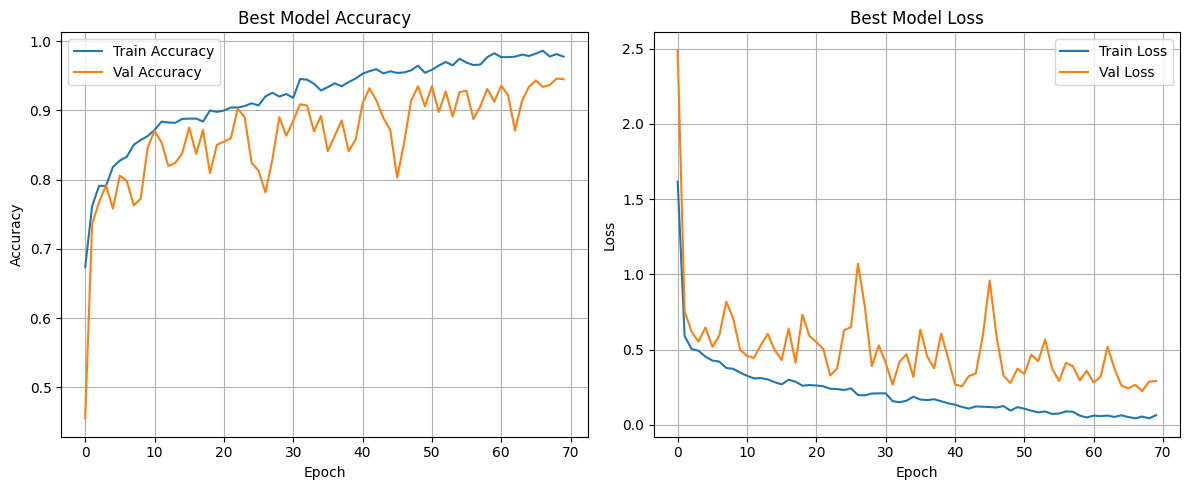

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
axs[0].plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
axs[0].set_title('Best Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(fine_tune_history.history['loss'], label='Train Loss')
axs[1].plot(fine_tune_history.history['val_loss'], label='Val Loss')
axs[1].set_title('Best Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

As shown above, the hyperband tuning was used to find the best classifier configuration. However, the resulting model did not perform well and only achieved 93.9% test accuracy with clear overfitting.

### Final Transfer Learning and Fine-Tuning

As a result of the previous performance, I decided to explore a different refined set of a paramaters as shown below

In [26]:
img_size=224
def build_resnet():
    # ResNet-50 feature extractor
    base = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(img_size, img_size, 3)
    )
    # We freeze the base model
    base.trainable = False        
    x = base.output
    x = GlobalAveragePooling2D()(x)  
    # Dense block 1
    x = Dense(256, activation="relu")(x) # Fully connected layer with ReLU
    x = Dropout(0.5)(x)                  # Dropout for regularisation
    # Dense block 2
    x = Dense(128, activation="relu")(x) # smaller dense layer
    x = Dropout(0.1)(x)        

    outputs = Dense(4, activation="softmax")(x)  

    model = Model(inputs=base.input, outputs=outputs)

    return model

# build the resnet model
model = build_resnet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,145,668 (92.11 MB)

 Trainable params: 557,956 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds_preprocessed,
    validation_data=val_ds_preprocessed,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10


I0000 00:00:1745935592.833683   19341 service.cc:152] XLA service 0x7f84b80027e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745935592.833755   19341 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-04-29 15:06:33.371531: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745935594.941271   19341 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-29 15:06:36.644165: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5013', 204 bytes spill stores, 204 bytes spill loads

2025-04-29 15:06:36.897684: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_

  1/135 ━━━━━━━━━━━━━━━━━━━━ 33:27 15s/step - accuracy: 0.1562 - loss: 1.7786

I0000 00:00:1745935602.151033   19341 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


133/135 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3116 - loss: 1.4098

2025-04-29 15:06:51.364415: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5013', 4 bytes spill stores, 4 bytes spill loads

2025-04-29 15:06:51.435674: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5013', 116 bytes spill stores, 116 bytes spill loads

2025-04-29 15:06:51.985886: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5013', 3940 bytes spill stores, 3920 bytes spill loads

2025-04-29 15:06:52.093808: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5013', 992 bytes spill stores, 992 bytes spill loads



135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3123 - loss: 1.4084

2025-04-29 15:06:58.263035: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1714', 4 bytes spill stores, 4 bytes spill loads

2025-04-29 15:07:03.093060: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 4 bytes spill stores, 4 bytes spill loads

2025-04-29 15:07:03.523503: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 220 bytes spill stores, 220 bytes spill loads

2025-04-29 15:07:03.803719: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 15:07:04.170025: I external/local

135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.3127 - loss: 1.4076 - val_accuracy: 0.4814 - val_loss: 1.1308
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.4398 - loss: 1.1624 - val_accuracy: 0.5483 - val_loss: 1.0963
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.4896 - loss: 1.1171 - val_accuracy: 0.5595 - val_loss: 1.0806
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.5159 - loss: 1.1031 - val_accuracy: 0.5827 - val_loss: 0.9981
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.5517 - loss: 1.0556 - val_accuracy: 0.6106 - val_loss: 1.0327
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.5474 - loss: 1.0572 - val_accuracy: 0.6431 - val_loss: 0.9392
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5521 - loss: 1.0221 - val_accuracy: 0.5353 - val_loss: 1.0739
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.5601 - loss: 1.0006 - val_accuracy: 0.6

In [8]:
# saving the initial model so we can reuse it
model.save('resnet50_1.keras')

In [8]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('resnet50_1.keras')


model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-6, patience=5, verbose=1)
model_mc = ModelCheckpoint('Resnet50_final.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Combine the callbacks into a list
callbacks = [model_rlr, model_mc]

for layer in model.layers:
    layer.trainable = True



In [9]:
model.compile(
    optimizer=Adam(learning_rate=1e-4), # reducing the learning rate
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,145,668 (92.11 MB)

 Trainable params: 24,092,548 (91.91 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
fine_tune_history = model.fit(
    train_ds_preprocessed,
    validation_data=val_ds_preprocessed,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1745935902.264135   20660 service.cc:152] XLA service 0x7f321c021c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745935902.264189   20660 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-04-29 15:11:43.480939: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745935907.744317   20660 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-29 15:11:51.256193: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14818', 204 bytes spill stores, 204 bytes spill loads

2025-04-29 15:11:51.487389: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm

134/135 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6136 - loss: 6.1995

2025-04-29 15:12:39.486616: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14818', 4 bytes spill stores, 4 bytes spill loads

2025-04-29 15:12:39.731230: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14818', 116 bytes spill stores, 116 bytes spill loads

2025-04-29 15:12:40.346633: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14818', 992 bytes spill stores, 992 bytes spill loads

2025-04-29 15:12:41.334059: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14818', 3940 bytes spill stores, 3920 bytes spill loads



135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6144 - loss: 6.1679

2025-04-29 15:13:03.720471: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1714', 4 bytes spill stores, 4 bytes spill loads

2025-04-29 15:13:08.030073: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 4 bytes spill stores, 4 bytes spill loads

2025-04-29 15:13:08.326066: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 220 bytes spill stores, 220 bytes spill loads

2025-04-29 15:13:08.832730: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 15:13:09.081921: I external/local

135/135 ━━━━━━━━━━━━━━━━━━━━ 117s 458ms/step - accuracy: 0.6153 - loss: 6.1367 - val_accuracy: 0.2658 - val_loss: 36.6923 - learning_rate: 1.0000e-04
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.8891 - loss: 0.3312 - val_accuracy: 0.2658 - val_loss: 31.1908 - learning_rate: 1.0000e-04
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.9367 - loss: 0.1821 - val_accuracy: 0.2658 - val_loss: 28.2267 - learning_rate: 1.0000e-04
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.9643 - loss: 0.1136 - val_accuracy: 0.2704 - val_loss: 25.2225 - learning_rate: 1.0000e-04
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.9709 - loss: 0.0914 - val_accuracy: 0.2853 - val_loss: 25.3004 - learning_rate: 1.0000e-04
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 172ms/step - accuracy: 0.9818 - loss: 0.0642 - val_accuracy: 0.3959 - val_loss: 9.3123 - learning_rate: 1.0000e-04
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 1

In [11]:
# Evaluate model on train, validation and test sets 
test_loss, test_acc = model.evaluate(val_ds_preprocessed)
print(f"Validation accuracy: {test_acc*100:0.4f}%")

test_loss, test_acc = model.evaluate(train_ds_preprocessed)
print(f"Train accuracy: {test_acc*100:0.4f}%")

test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9783 - loss: 0.1578
Validation accuracy: 98.2342%
134/135 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9995 - loss: 0.0016

2025-04-29 15:50:02.233244: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1714', 12 bytes spill stores, 12 bytes spill loads



135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9995 - loss: 0.0016
Train accuracy: 99.9071%
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9746 - loss: 0.1524

2025-04-29 15:50:07.765879: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 12 bytes spill stores, 12 bytes spill loads

2025-04-29 15:50:07.945716: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 15:50:07.961726: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 15:50:07.994607: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1700', 112 bytes spill stores, 112 bytes spill loads

2025-04-29 15:50:09.012431: I external/loc

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.9750 - loss: 0.1526
Test accuracy: 98.2169%


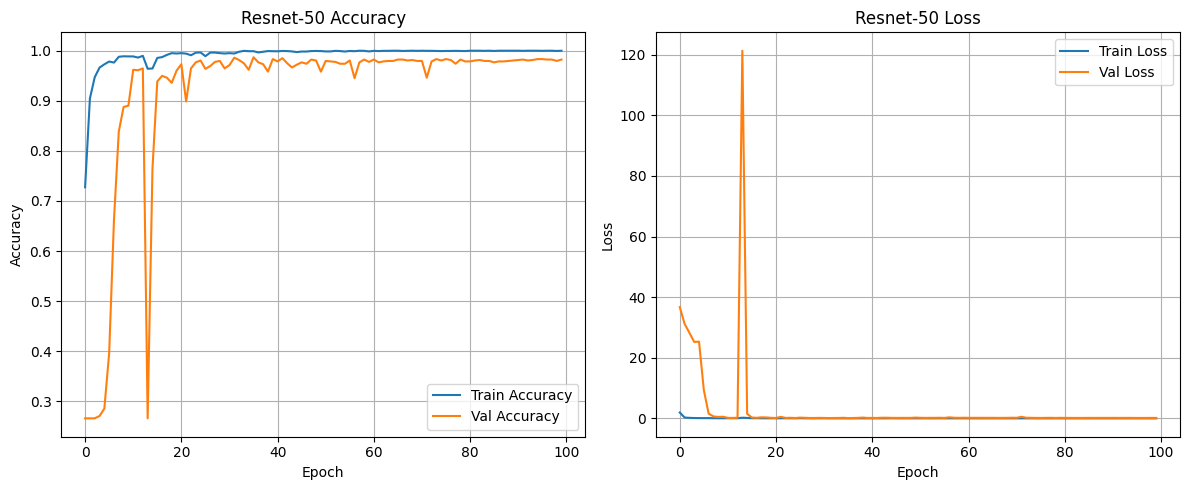

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
axs[0].plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
axs[0].set_title('Resnet-50 Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(fine_tune_history.history['loss'], label='Train Loss')
axs[1].plot(fine_tune_history.history['val_loss'], label='Val Loss')
axs[1].set_title('Resnet-50 Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

This custom version clearly performs better than the previous tuned Resnet-50 version

# Evaluation:

In [7]:
# Loading the models
custom_cnn_model = load_model("best_custom_cnn.keras")
resnet_model = load_model("Resnet50_final.keras")

## Models Comparison

In [11]:
# Extracting all images and their labels
all_images = []
all_labels = []

for images, labels in test_ds_preprocessed:
    all_images.append(images)
    all_labels.append(labels)

# combining all batches 
all_images= tf.concat(all_images,axis=0)
all_labels= tf.concat(all_labels,axis=0)
true_labels= all_labels.numpy()

# predciting all images for each model
predictions_cnn = custom_cnn_model.predict(all_images, verbose= False)
predictions_resnet = resnet_model.predict(all_images, verbose= False)

# getting the predicted labels
predicted_labels_cnn = np.argmax(predictions_cnn,axis=1)
predicted_labels_resnet = np.argmax(predictions_resnet,axis=1)


2025-05-05 01:52:36.365039: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-05 01:52:36.737633: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 810442752 exceeds 10% of free system memory.
I0000 00:00:1746406357.072004  162977 service.cc:152] XLA service 0x2b156380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746406357.072047  162977 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-05-05 01:52:37.080920: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746406357.117155  162977 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-05 01:52:37.797756: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning

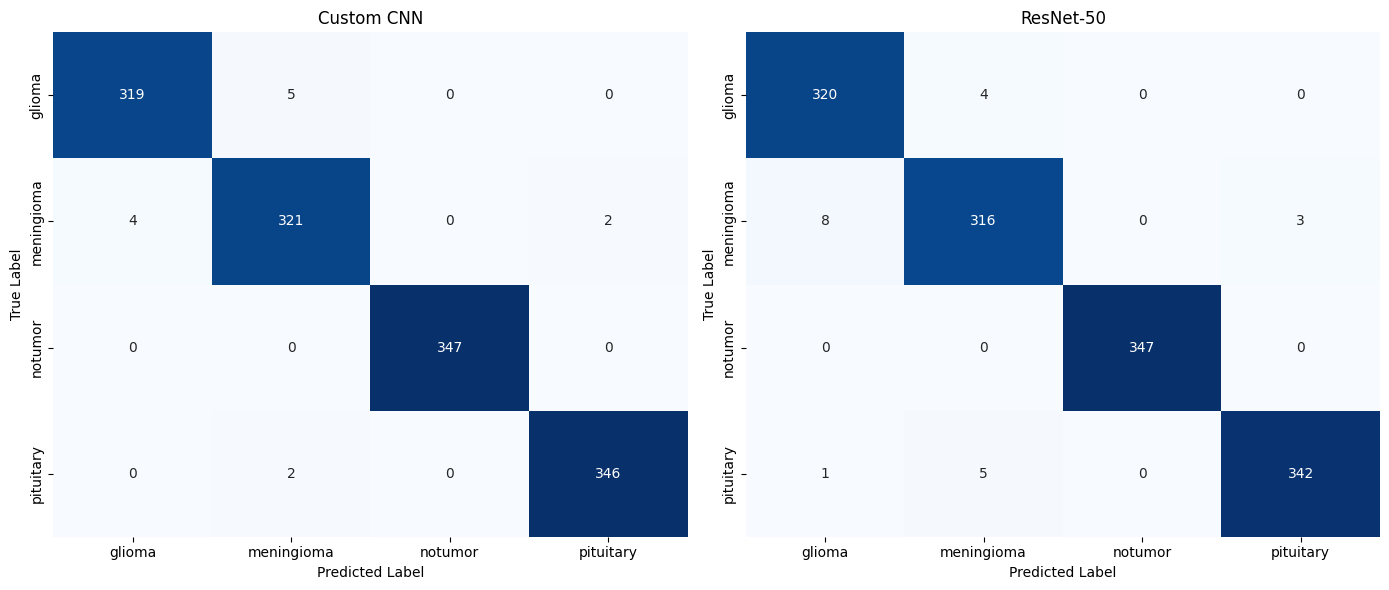

In [12]:
class_ids   = [0,1,2,3] # integer labels

cm_cnn = confusion_matrix(true_labels, predicted_labels_cnn, labels=class_ids)
cm_resnet = confusion_matrix(true_labels, predicted_labels_resnet, labels=class_ids)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot custom CNN confusion matrix
sns.heatmap(
    cm_cnn,
    annot=True,
    fmt="d",
    cmap='Blues',
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[0]
)
axes[0].set_title("Custom CNN")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Plot ResNet-50 confusion matrix
sns.heatmap(
    cm_resnet,
    annot=True,
    fmt="d",
    cmap='Blues',
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[1]
)
axes[1].set_title("ResNet-50")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [13]:
print("Custom CNN Classification Report")
print(classification_report(true_labels, predicted_labels_cnn, target_names=class_names, digits=3))

print("\nResNet-50 Classification Report")
print(classification_report(true_labels, predicted_labels_resnet, target_names=class_names, digits=3))


Custom CNN Classification Report
              precision    recall  f1-score   support

      glioma      0.988     0.985     0.986       324
  meningioma      0.979     0.982     0.980       327
     notumor      1.000     1.000     1.000       347
   pituitary      0.994     0.994     0.994       348

    accuracy                          0.990      1346
   macro avg      0.990     0.990     0.990      1346
weighted avg      0.990     0.990     0.990      1346


ResNet-50 Classification Report
              precision    recall  f1-score   support

      glioma      0.973     0.988     0.980       324
  meningioma      0.972     0.966     0.969       327
     notumor      1.000     1.000     1.000       347
   pituitary      0.991     0.983     0.987       348

    accuracy                          0.984      1346
   macro avg      0.984     0.984     0.984      1346
weighted avg      0.984     0.984     0.984      1346



In [15]:
# storing the datasets in a dictionary
datasets = {
    'Train': train_ds_preprocessed,
    'Validation': val_ds_preprocessed,
    'Test': test_ds_preprocessed
}

results = []

# iterating through the dictionary
for split, ds in datasets.items():
    # Evaluating both models
    cnn_loss, cnn_acc = custom_cnn_model.evaluate(ds,verbose=False)
    resnet_loss, resnet_acc = resnet_model.evaluate(ds, verbose=False)

    #Adding the results to the list
    results.append({
        'Dataset': split,
        'Custom CNN Accuracy (%)': round(cnn_acc * 100, 3),
        'ResNet-50 Accuracy (%)': round(resnet_acc * 100, 3),
    })

df_results = pd.DataFrame(results)
display(df_results)

Dataset  Custom CNN Accuracy (%)  ResNet-50 Accuracy (%)
0       Train                  100.000                  98.792
1  Validation                   98.513                  98.699
2        Test                   99.034                  98.440

## Correct and incorrect predictions (Custom CNN)

I0000 00:00:1746450804.323677   12693 service.cc:152] XLA service 0x7f5928003c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746450804.323819   12693 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-05-05 14:13:24.377389: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746450804.693286   12693 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-05 14:13:25.493657: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_79', 4 bytes spill stores, 4 bytes spill loads

2025-05-05 14:13:25.616813: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion

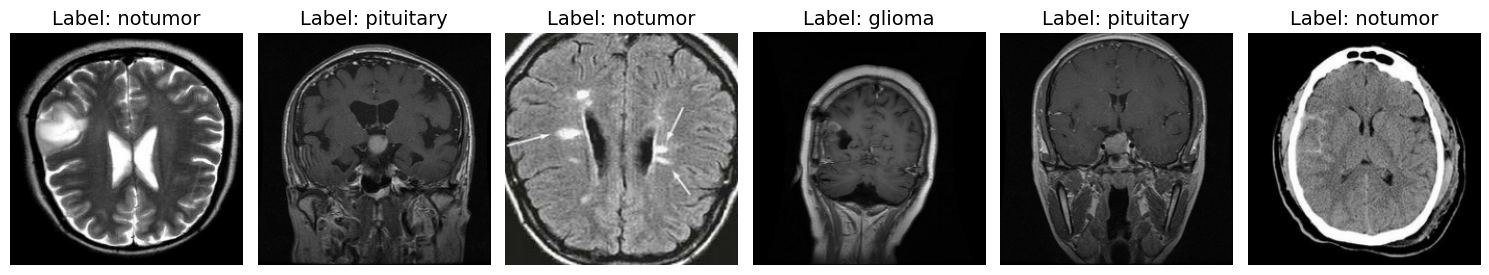

2025-05-05 14:13:38.615371: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


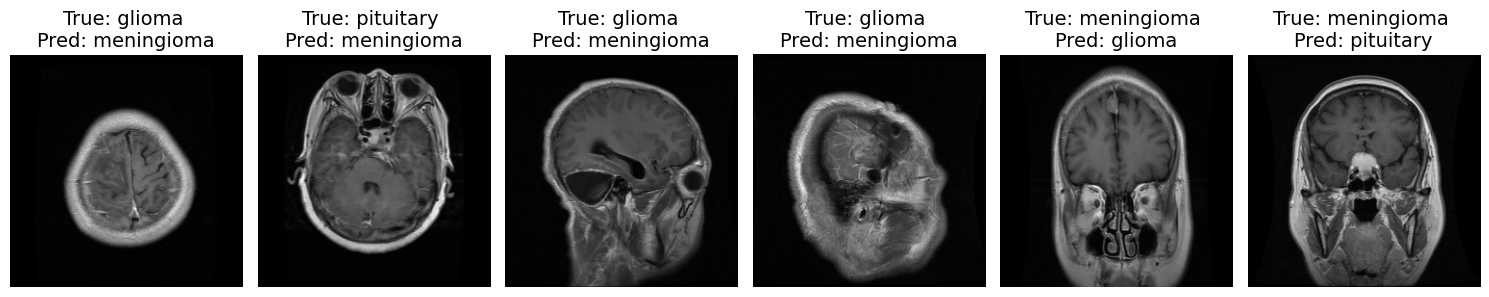

In [8]:
def visualise_classified_images(dataset, model, class_names, num_images, correct):
    results = []

    for images,true_labels in dataset:
        preds = model.predict(images, verbose= False)
        predicted_labels = np.argmax(preds, axis=1)
        true_labels= true_labels.numpy() # convert tensor to numpy array 


        # we loop through the images, true labels and correct ones
        for img, true, pred in zip(images, true_labels, predicted_labels):
            # we add the correctly classified images 
            if correct and (true == pred):
                results.append((img.numpy(), class_names[true]))
            # we add the misclassified images, the true label and the wrong prediction
            elif not correct and (true != pred):
                results.append((img.numpy(), class_names[true],class_names[pred]))
            # we stop once we reach the desired number of images
            if len(results) == num_images:
                break
    
    plt.figure(figsize=(15,4))
    for i in range(num_images):# we loop through the collected images
        plt.subplot(1,num_images,i+1)
        img = (results[i][0]*255).astype("uint8") # we convert the normalized pixel values to 0-255 (uint8)
        plt.imshow(img)
        if correct:
            plt.title(f'Label: {results[i][1]}',fontsize= 14)
        else:
            plt.title(f'True: {results[i][1]} \nPred: {results[i][2]}',fontsize=14)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# visualising correctly classified images
visualise_classified_images(test_ds_preprocessed, custom_cnn_model,class_names, num_images=6,correct=True)

# visualising misclassified images with their true label
visualise_classified_images(test_ds_preprocessed, custom_cnn_model,class_names, num_images=6,correct=False)

## Grad-CAM Visualizations

In [8]:
# Function that will create the grad-cam heatmap
# Source: https://keras.io/examples/vision/grad_cam/#the-gradcam-algorithm

def make_gradcam_heatmap (img_array, model, last_conv_layer_name, pred_index):
    # We get the output of the last convolutional layer
    last_conv_layer_output = model.get_layer(last_conv_layer_name).output

    # we take the output of the last convolutional layer, and we loop through the rest of the model's layers to rebuild the predictions
    x = last_conv_layer_output
    for layer in model.layers[model.layers.index(model.get_layer(last_conv_layer_name)) + 1:]:
        x = layer(x)

    # create a model that maps the input image to the activations of the last conv layer and the output predictions
    grad_model = Model(inputs=model.layers[0].input,
                      outputs=[last_conv_layer_output, x])
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [9]:
def superimpose_heatmap(img, heatmap, alpha):
    img_display = (img*255).astype(np.uint8)

    heatmap_rgb= plt.get_cmap("jet")(heatmap)[:, :, :3]*255

2025-05-06 00:22:23.587343: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1746487343.721627    4121 service.cc:152] XLA service 0x7f2c94003730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746487343.721681    4121 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-05-06 00:22:23.756383: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746487343.829389    4121 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746487345.062739    4121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


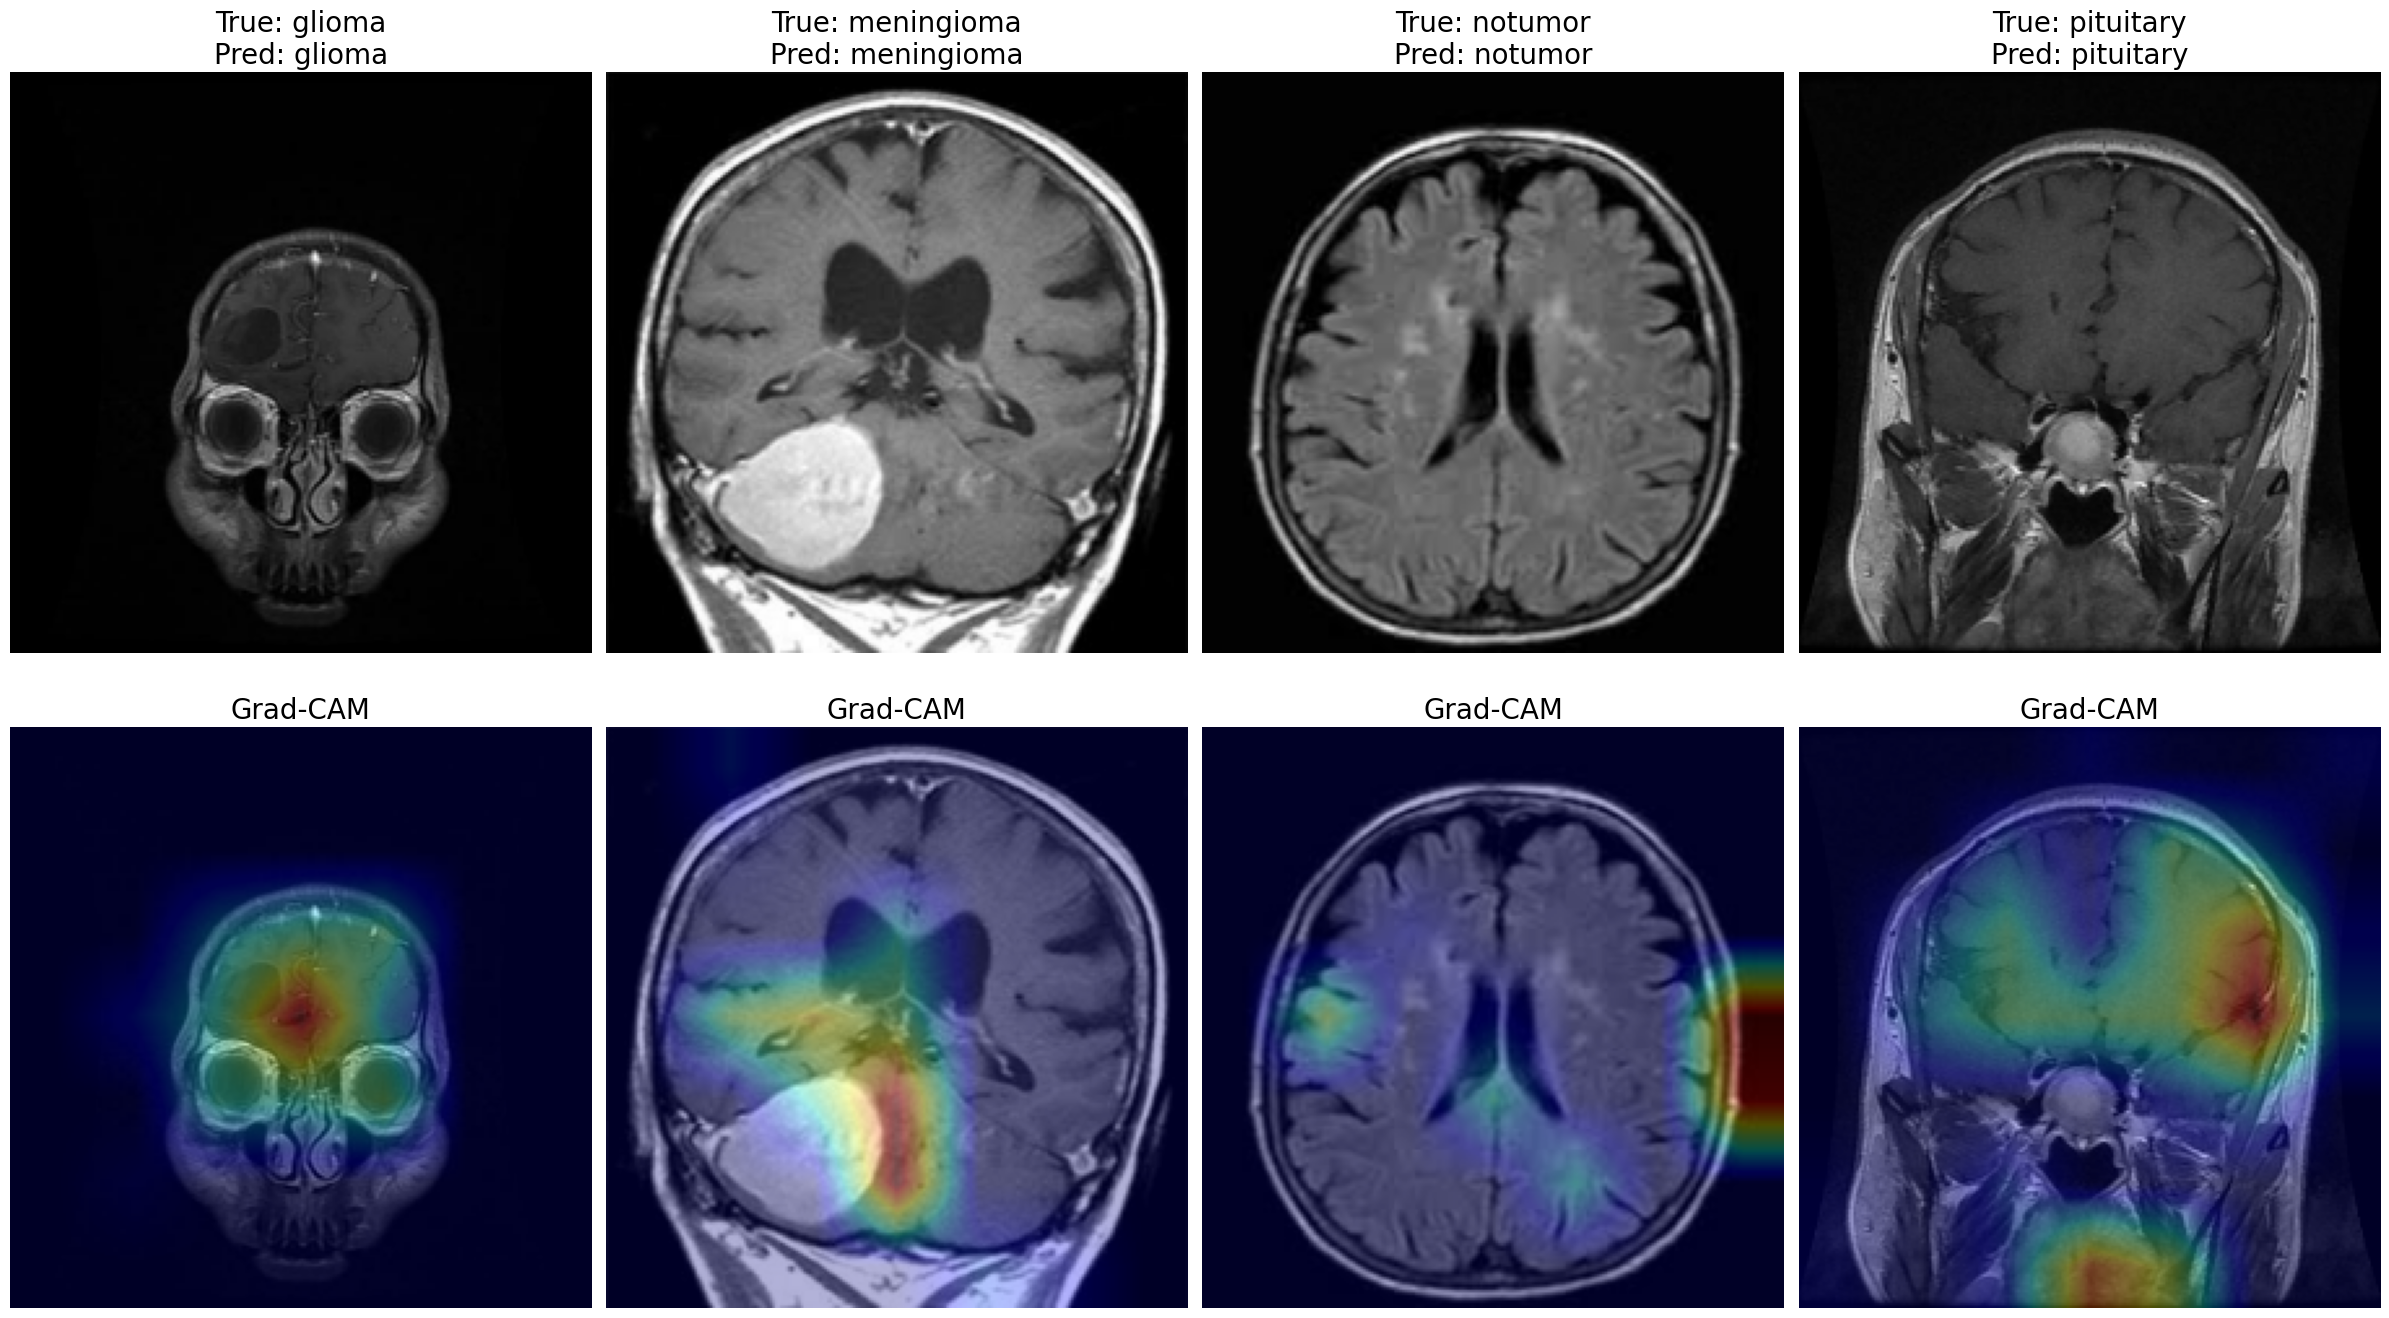

In [10]:
import matplotlib.pyplot as plt

def superimpose_heatmap(img, heatmap, alpha=0.3):
 
    # Scale image to 0-255 if necessary
    img_display = (img * 255).astype(np.uint8)

    # Apply the jet colormap to the heatmap
    heatmap_rgb = plt.get_cmap("jet")(heatmap)[:, :, :3] * 255

    # Superimpose heatmap on the original image
    superimposed_img = (alpha * heatmap_rgb + (1 - alpha) * img_display).astype('uint8')

    return superimposed_img


# Function has been defined just in the data preparation section (see above data augmentation)
images_per_class = get_one_image_per_class(test_ds_preprocessed)

plt.figure(figsize=(24, 14))

# Unique images has been pre defined in data augmentation section
for class_idx, img in images_per_class.items():
    # we add the batch dimension to the image
    img_array = tf.expand_dims(img, axis=0)
    # we get the image to display
    img_display = (img * 255).astype(np.uint8)

    # we predict the image class (diagnosis)
    preds = custom_cnn_model.predict(img_array, verbose=0)
    predicted_index = np.argmax(preds[0])
    

    # perform the grad-cam heatmap for the predicted class
    heatmap = make_gradcam_heatmap(img_array, custom_cnn_model, 'conv2d_3', pred_index=predicted_index)
    # resize the heatmap, matching the input size
    heatmap = tf.image.resize(tf.expand_dims(heatmap, axis = -1), (img.shape[0], img.shape[1])).numpy().squeeze()
    superimposed_img = superimpose_heatmap(img,heatmap, alpha=0.3)


    true_class = class_names[class_idx]
    predicted_class = class_names[predicted_index]

    plt.subplot(2, len(class_names), class_idx + 1)
    plt.imshow(img_display)
    # Displaying the true label and predicted label
    plt.title(f"True: {true_class}\nPred: {predicted_class}",fontsize=20)
    plt.axis('off')

    plt.subplot(2, len(class_names), len(class_names) + class_idx + 1)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM", fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Deployment

In [11]:
# Function to get prediction and generate the grad-cam heatmap
def predict(image):
    img = image.resize((224, 224)) # resize the image because the model was trained on 224x224 images
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = custom_cnn_model.predict(img_array)[0]
    predicted_index = np.argmax(preds)
    confidence = preds[predicted_index] * 100 # we get the confidence levels of the prediction

    predicted_class = class_names[predicted_index]

    # Grad-cam heatmap and the superimposed image (function defined in the Grad-cam section)
    heatmap = make_gradcam_heatmap(img_array, custom_cnn_model, 'conv2d_2', predicted_index)
    heatmap_resized = tf.image.resize(
        tf.expand_dims(heatmap, axis=-1),
        (img.size[1], img.size[0])
    ).numpy().squeeze()

    superimposed_img = superimpose_heatmap(np.array(img) / 255.0, heatmap_resized, alpha=0.3)

    color = "#28a745" if confidence > 80 else "#ffc107"  # Green if confidence is over 80%, yellow if not
    
    # Styling the output
    text_output = f"""
    <div style="
    border: 2px solid {color};
    border-radius: 12px;
    padding: 16px;
    background-color: rgba(0, 0, 0, 0.03);
    color: inherit;
    box-shadow: 2px 2px 10px rgba(0,0,0,0.1);
    ">
    <h3 style="color: {color}; margin-top: 0;">Predicted Tumor Type: {predicted_class.upper()}</h3>
    <p style="font-size: 18px; margin-bottom: 0;">Confidence: {confidence:.2f}%</p>
    </div>
    """
    
    return text_output, Image.fromarray(superimposed_img)


with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """
        <h1 style='text-align: center; color: #4A90E2;'>Brain Tumor Detection</h1>
        <p style='text-align: center; font-size: 16px;'>Upload a brain scan image to get the predicted tumor type and see the highlighted region of interest /p>
        """
    )

    # Image upload
    with gr.Row():
        image_input = gr.Image(type="pil", label="Upload Brain Scan")
    
    # button to get the prediction
    predict_button = gr.Button("Analyze Image", size="lg")

    with gr.Row():
        with gr.Column(scale=1):    # one column for the prediction result
            output_html = gr.HTML(label="Prediction Result")
        with gr.Column(scale=1):    # one column for the grad-cam image result
            grad_cam_output = gr.Image(label="Highlighted region (Grad-CAM)")

    # Linking the predict button with the actual function resulting in the prediction result and the grad-cam image
    predict_button.click(
        fn=predict,
        inputs=image_input,
        outputs=[output_html, grad_cam_output]
    )

    # Disclaimer
    gr.Markdown(
        """
        <p style='text-align: center; font-size: 14px; color: gray; font-weight:bold'>
         This tool is for educational and research purposes only. Please do not use it for medical diagnosis.
        </p>
        """
    )

demo.launch(share = True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://40ad01656cc5a1e0ca.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
